# Quantum Algorithms

This notebook contains exercises for the QT course on Quantum Algorithms.

We show an example hybrid algorithm to generate probability distributions. The example has no real-world applications (sampling from probablity distributions can be done classically), but it shows many the aspects of hybrid algorithm in a simple setting. 

The section Bell states contains exercises that can be performed using the QI public website.

<pieter.eendebak@tno.nl>

In [27]:
from functools import partial
import copy

import matplotlib.pyplot as plt

import numpy as np
from qiskit import Aer, QuantumCircuit
from qiskit.algorithms.optimizers import SPSA
from qiskit.visualization import plot_histogram
from qiskit.circuit import Parameter, QuantumCircuit
from rich import print as rprint

def fdict(d : dict, fmt : str = '.2f') -> dict:
  """ Format mapping with float values """
  return {k: f'{v:{fmt}}' for k, v in d.items()}
  
plt.rcParams["figure.figsize"] = (8, 6)
backend = Aer.get_backend("aer_simulator")

# Hybrid algorithms

In this section you will run (hybrid) algorihms using Python. To install the required dependencies run
```
>>> pip install qiskit quantuminspire
```

## Unfair coin

Using a quantum circuit and a classical optimizer we create a user specified
probability distributions. 
We start with an unfair coin. The outcomes of tossing the coin are head, 
with probability $p$, or tail, with probability $q=1-p$.

We represent our coin with a single qubit and the process of tossing the coin with a measurement
in the computational basis. The outcome $|0\rangle>$ corresonds to head, the outcome $|1\rangle$ corresponds to tail.

To create the random component, we initialize the qubit and then apply a parameterized circuit.

We select a target probability for heads and define the corresponding probability distribution.

In [34]:
p = 0.5 + 0.25 * np.random.random()
target_distribution = {0: p, 1: 1 - p}

Hybrid algorithms consist of 3 components: the parameterized **ansatz**, the **objective** function (often quantum) and the classical **optimizer**. We start with the ansatz for our problem. The ansatz is a single-qubit circuit. Since our problem has only a single degree of freedom (the probablity $p$), we try a ciruit with only a single parameter.

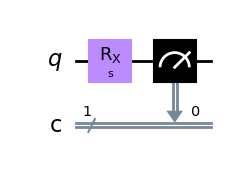

In [35]:
s = Parameter("s")

def generate_ansatz(params):
    qc = QuantumCircuit(1, 1)
    qc.rx(params[0], 0)
    qc.measure(0, 0)
    return qc

qc = generate_ansatz([s])
qc.draw(output="mpl")

The objective function compares the generated distribution with the target distribution.

In [36]:
def counts_to_distr(counts) -> dict[int, float]:
    """Convert Qiskit result counts to a dictionary

    The dictionary has integers as keys, and pseudo-probabilities as values.
    """
    n_shots = sum(counts.values())
    output_distr = {int(k, 2): v / n_shots for k, v in counts.items()}
    return {k: output_distr[k] for k in sorted(output_distr)}


def objective_function(params, target_distribution, backend):
    """Compares the output distribution of our circuit with
    parameters `params` to the target distribution."""
    # Create circuit instance with paramters and simulate it
    qc = generate_ansatz(params)
    result = backend.run(qc).result()
    # Convert the result to a dictionary with probabilities
    output_distr = counts_to_distr(result.get_counts())
    # Calculate the cost as the distance between the output
    # distribution and the target distribution
    cost = sum(abs(target_distribution.get(i, 0) - output_distr.get(i, 0)) for i in range(2**qc.num_qubits))
    return cost

For the classical optimizer we use [SPSA](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.SPSA.html).

In [37]:
optimizer = SPSA(maxiter=500)

params = np.random.rand(1)
F = partial(objective_function, target_distribution=target_distribution, backend=backend)
result = optimizer.minimize(fun=F, x0=params)

# Obtain the output distribution using the final parameters
qc = generate_ansatz(result.x)
counts = backend.run(qc, shots=10000).result().get_counts()
output_distr = counts_to_distr(counts)
output_distr = {k: output_distr[k] for k in sorted(output_distr)}

print(f"Parameters found: {result.x}, cost {F(result.x):.3g}")
print(f"Target Distribution: {fdict(target_distribution)}")
print(f"Obtained Distribution: {fdict(output_distr)}")

Parameters found: [1.12178704], cost 0.0586
Target Distribution: {0: '0.72', 1: '0.28'}
Obtained Distribution: {0: '0.71', 1: '0.29'}


Sample 10 times from the distribution to simulate coin flips

In [39]:
print(f"p {p:.3f}")
for ii in range(10):
        counts = backend.run(qc, shots=1).result().get_counts()
        value = "head" if counts.get("0", 0) == 1 else "tail"
        print(f"toss {ii}: {value}")

p 0.725
toss 0: tail
toss 1: head
toss 2: head
toss 3: head
toss 4: head
toss 5: head
toss 6: head
toss 7: head
toss 8: head
toss 9: tail


Side note : how much variation do we expect in a generated distribution?

In [9]:
N = 1024  # default number of shots for backend
px = np.array(list(target_distribution.values()))
s = np.sqrt(px * (1 - px) / N)
print(f"p {p:.3f}: Expected std in measurement at {N} shots: {s}")

p 0.726: Expected std in measurement at 1024 shots: [0.01393519 0.01393519]


## Exercise: QI SDK
Use the QI SDK to sample from the probability distribution on a QI backend.
Options are the `QX single-node simulator`  or `starmon-5` 

Note: you need an account for this. For details see https://github.com/QuTech-Delft/quantuminspire

### Solution

In [ ]:
from quantuminspire.credentials import get_token_authentication, load_account
from quantuminspire.qiskit import QI

number_of_samples = 15

authentication = get_token_authentication(load_account())

backend_name = "QX single-node simulator"
# backend_name = "Starmon-5"
QI.set_authentication(authentication)
qi_backend = QI.get_backend(backend_name)
number_of_shots = 2 * 2048
qi_backend.options.shots = number_of_shots  # for starmon-5 overhead is in compilation


r = qi_backend.run(qc, shots=number_of_samples).result()

samples = [int(v, 0) for v in r.results[0].data.memory]
print(f"{len(samples)} samples for p={p:.2f}: {samples}")

# Hint: for starmon-5 one needs to embed the single-qubit circuit in a 5 qubit circuit.
# See qtt.utils.qiskit.circuits.integrate_circuit and qiskit.result.marginal_counts

In [ ]:
# Not working, see https://github.com/QuTech-Delft/quantuminspire/issues/155https://github.com/QuTech-Delft/quantuminspire/issues/155
if 0:
    for ii in range(10):
        counts = qi_backendqi_backend.run(qc, shots=1).result().get_counts()
        value = "head" if counts.get("0", 0) == 1 else "tail"
        print(f"toss {ii}: {value}")

## Exercise: convergence
Show the convergence of the classical optimizer
Add a callback method to the SPSA constructor to record the optimization values at each step.
Plot the result as a function of the iteration step

### Hint

Install qtt using `!pip install qttpte`. One can then use the `OptimizerCallback` class

### Solution

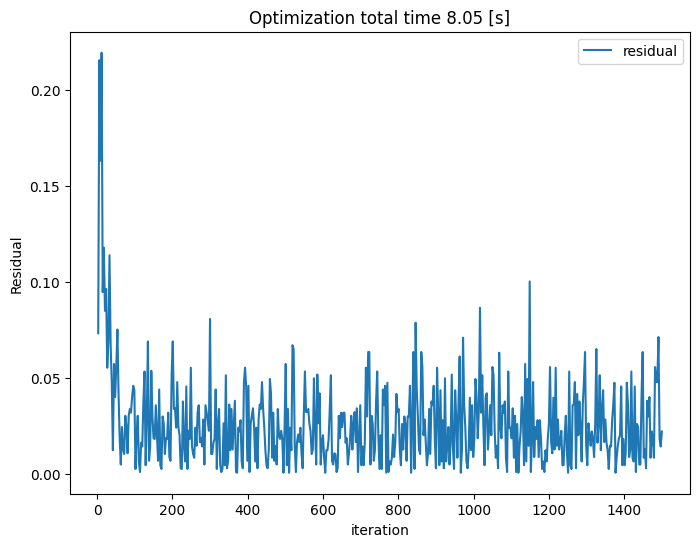

In [11]:
# Solution
from qtt.utilities.optimization import OptimizerCallback

callback = OptimizerCallback()
optimizer = SPSA(maxiter=500, callback=callback.qiskit_callback)

params = np.random.rand(3)
result = optimizer.minimize(fun=F, x0=params)
callback.plot()

# Remarks: note that the optimization convergence was fast. Within a few iterations we reached a steady state where the cost function

## Exercise: create a probability distribution for a 4-sided dice

Variation: create an $2^k$-sided dice

### Solution

{0: 0.11020587663414064, 1: 0.3426907881894855, 2: 0.389330748837873, 3: 0.15777258633850083}

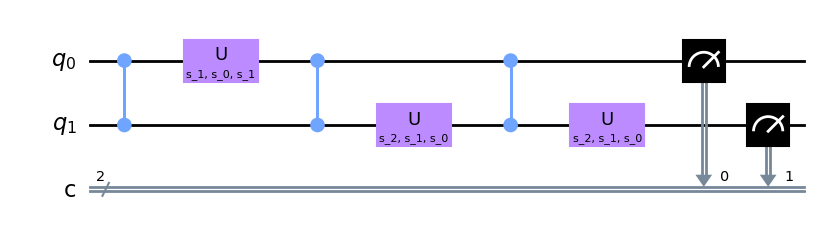

In [13]:
number_of_qubits = 2
m = 2**number_of_qubits
p0 = np.random.random(m) + 0.2
p0 = p0 / np.sum(p0)
target_distribution = {k: p0[k] for k in range(m)}


def generate_ansatz(params):
    qc = QuantumCircuit(number_of_qubits, number_of_qubits)
    qc.cz(0, 1)
    qc.u(params[1], params[0], params[1], 0)
    qc.cz(0, 1)
    qc.u(params[2], params[1], params[0], 1)
    qc.cz(0, 1)
    qc.u(params[2], params[1], params[0], 1)
    for ii in range(number_of_qubits):
        qc.measure(ii, ii)
    return qc

rprint(target_distribution)

qc = generate_ansatz([Parameter(f"s_{i}") for i in range(3)])
qc.draw(output="mpl")

Parameters Found: [-0.49189353  1.55096897  1.56981008]
Target Distribution: {0: '0.11', 1: '0.34', 2: '0.39', 3: '0.16'}
Obtained Distribution: {0: '0.13', 1: '0.36', 2: '0.39', 3: '0.12'}
Cost: 0.08444104535274768


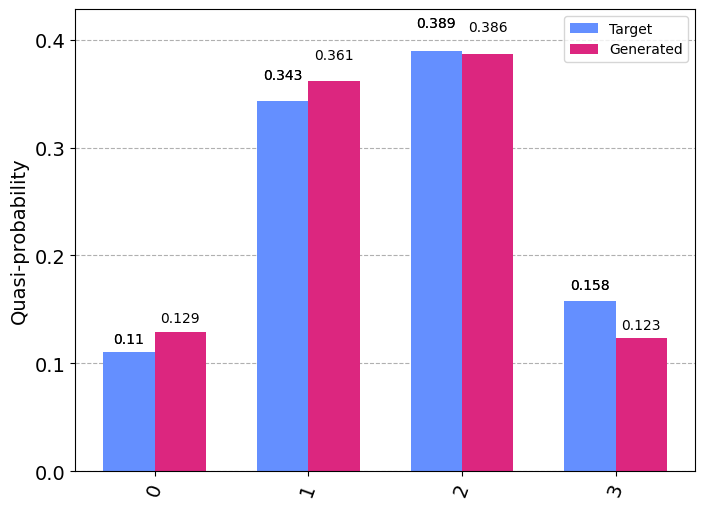

In [26]:
F = partial(objective_function, target_distribution=target_distribution, backend=backend)

optimizer = SPSA(maxiter=300)

result = optimizer.minimize(fun=F, x0=np.random.rand(3))

# Obtain the output distribution using the final parameters
qc = generate_ansatz(result.x)
counts = backend.run(qc, shots=10000).result().get_counts()
output_distribution = counts_to_distr(counts)

print("Parameters Found:", result.x)
print(f"Target Distribution: {fdict(target_distribution)}")
print(f"Obtained Distribution: {fdict(output_distribution)}")

plot_histogram([target_distribution, output_distribution], ax=plt.gca(), legend=["Target", "Generated"])
plt.legend();
# plot_histogram(target_distribution, ax=plt.gca())
# plot_histogram(output_distr, ax=plt.gca())

## Exercise: generate a (fair) 3-sided dice

This requires some creativity, since 3 is not a power of 2.

### Solution

This is a bit tricky, as our measurements always result in 2^k states.
We could cheat a bit and generate 4 values and just discard the third component, but this requires classical processing which we want to avoid.
So we cheat just a tiny bit: we take 2-qubits and assign the outcomes as: $|00\rangle \rightarrow$ side 1, $|01\rangle \rightarrow$ side 2, $|10\rangle \rightarrow$  side 3 and $|11\rangle \rightarrow$ side 3.
We have to modify the objective method for this though

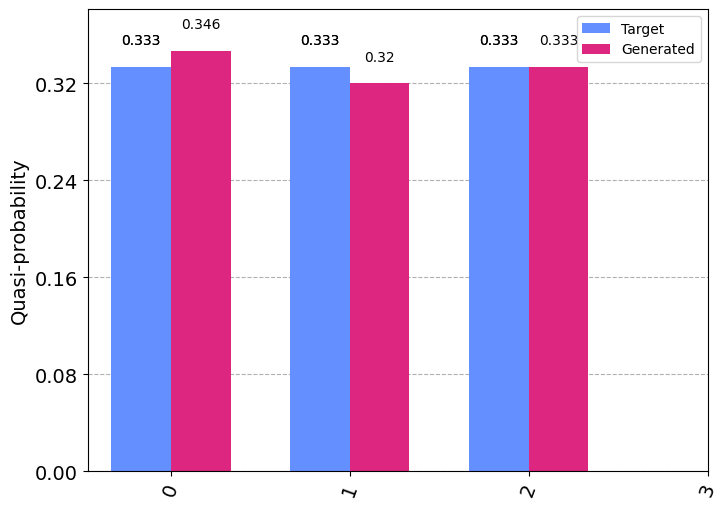

In [28]:
def distrubution_to_three_sided(output_distr):
    output_distr = copy.copy(output_distr)
    output_distr[2] = output_distr.get(2, 0) + output_distr.get(3, 0)
    output_distr[3] = 0
    return output_distr

def objective_function(params, target_distribution):
    """Compares the output distribution of our circuit with
    parameters `params` to the target distribution."""
    qc = generate_ansatz(params)
    result = backend.run(qc).result()
    output_distr = distrubution_to_three_sided(counts_to_distr(result.get_counts()))
    cost = sum(abs(target_distribution.get(i, 0) - output_distr.get(i, 0)) for i in range(2**qc.num_qubits))
    return cost

target_distribution = {0: 1 / 3, 1: 1 / 3, 2: 1 / 3}
F = partial(objective_function, target_distribution=target_distribution)
result = optimizer.minimize(fun=F, x0=params)

qc = generate_ansatz(result.x)
counts = backend.run(qc, shots=10000).result().get_counts()
output_distribution = counts_to_distr(counts)
output_distribution = distrubution_to_three_sided(output_distribution)

plot_histogram([target_distribution, output_distribution], ax=plt.gca(), legend=["Target", "Generated"])
plt.legend();

# Bell states

In this section you will run circuits using the QI public website. The link is

https://www.quantum-inspire.com/projects/new


The Bell state is the prime example of an entangled state. In can be created with the following quantum circuit.

In [ ]:
from qiskit import QuantumCircuit

bell = QuantumCircuit(2)
bell.h(0)
bell.cnot(0, 1)
bell.measure_all()
bell.draw(output="mpl")

## Exercise: program a Bell state on the QI website

### Solution

The following cqasm code generates a Bell state:
```
version 1.0
qubits 2
H q[0]
CNOT q[0], q[1]
```

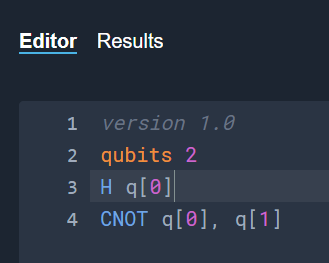

## Exercise: different Bell states

The Bell state introduced above is used most often in examples, but there are in fact 4 2-qubit Bell states. The first two are

$$|\Phi^+ \rangle > = \frac{|00> + |11>}{2}, |\Phi^- \rangle > = \frac{|00> - |11>}{2}$$

Together the 4 Bell states span the entire 4 dimensional state space of a 2-qubit system.

What could the remaining 2 Bell states be?

### Solution

Remaining two bell States:
$$|\Psi^+ \rangle > = \frac{|01> + |10>}{2}, |\Psi^- \rangle > = \frac{|01> - |10>}{2}$$

## Exercise: programming different Bell states

Program the two other Bell states

### Solution

The $|\Phi^-\rangle$ state can be constructed with

```
qubits 2
H q[0]
CNOT q[0], q[1]
X q[1]
```

## Exercise: GHZ states

A generalization of the Bell state is the GHZ ([Greenberger-Horne-Zeiliger](https://en.wikipedia.org/wiki/Greenberger%E2%80%93Horne%E2%80%93Zeilinger_statehttps://en.wikipedia.org/wiki/Greenberger%E2%80%93Horne%E2%80%93Zeilinger_state)) state. The GHZ state has applications
in quantum communication and as a building block in quantum algorithms. For a 3-qubit system it is

$$\frac{|000\rangle + |111\rangle}{2} $$

Program the GHZ state and measure the result.

### Solution

cqasm code is:
```
# GHZ state
qubits 3
H q[0]
CNOT q[0], q[1]
CNOT q[0], q[2]
```


End of the exercises.